# Building

In [34]:
import pandas as pd
import numpy as np
import pathlib
import sys
from cobra.io import read_sbml_model

#sys.path.append(r"C:/Users/Utilizador/OneDrive - Universidade do Minho/IPK/Code/Models")
#sys.path.append(r"/home/tiagomachado/OneDrive/IPK/Code/Models/")

from model_functions import *
from cobra.flux_analysis import flux_variability_analysis
from cobra import flux_analysis, Reaction

#General Core Model
general_model = read_sbml_model('PlantCoreMetabolism_v2_0_0_deprotonated.sbml')

In [35]:
"""
Maize Biomass
"""
#Create the biomass reaction
reaction = Reaction('Maize_biomass_tx')
reaction.name = 'Maize biomass'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.

#Import the pandas dataframe
df = pd.read_csv("Final_Biomass_V1.csv")

#Get a list with the metabolite IDs from the generic model
met_list = []

for id in df.loc[:,"Ids"]:
    met = general_model.metabolites.get_by_id(id)
    met_list.append(met)

#Create a list with the coefficients
coef = list(df.loc[:,"Maize"])

#Add metabolites to the model: dictionary - keys are metabolites and values are the coefficients
for i in range(len(coef)):
    reaction.add_metabolites({met_list[i]:coef[i]})

#Add reaction to the model
general_model.add_reactions([reaction])

In [36]:
"""
Arabidopsis biomass
"""

reaction = Reaction('Arabidopsis_biomass_tx')
reaction.name = 'Arabidopsis biomass'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default

#Import the pandas dataframe
df = pd.read_csv("Final_Biomass_V1.csv")

#Get a list with the metabolite IDs from the generic model
met_list = []

for id in df.loc[:, "Ids"]:
    met = general_model.metabolites.get_by_id(id)
    met_list.append(met)

#Create a list with the coefficients
coef = list(df.loc[:, "Arabidopsis"])

#Add metabolites to the model: dictionary - keys are metabolites and values are the coefficients
for i in range(len(coef)):
    reaction.add_metabolites({met_list[i]: coef[i]})

#Add reaction to the model
general_model.add_reactions([reaction])

In [37]:
"""
Malate/Pyruvate Transporter
"""

MAL_c = general_model.metabolites.MAL_c
MAL_p = general_model.metabolites.MAL_p
PYRUVATE_c = general_model.metabolites.PYRUVATE_c
PYRUVATE_p = general_model.metabolites.PYRUVATE_p

#Create the biomass reaction
transporter = Reaction('PYR_MAL_pc')
transporter.name = 'Malate/Pyruvate Transport'
transporter.lower_bound = -1000.  # This is the default
transporter.upper_bound = 1000.

transporter.add_metabolites({
    PYRUVATE_p: -1.0,
    MAL_c: -1.0,
    PYRUVATE_c: 1.0,
    MAL_p: 1.0
})

general_model.add_reactions([transporter])

In [38]:
"""
Asp/OAA transporter
"""

# OAA_c = general_model.metabolites.OXALACETIC_ACID_c
# OAA_p = general_model.metabolites.OXALACETIC_ACID_p
# ASP_c = general_model.metabolites.L_ASPARTATE_c
# ASP_p = general_model.metabolites.L_ASPARTATE_p
#
# #Create the biomass reaction
# transporter = Reaction('ASP_OAA_pc')
# transporter.name = 'Aspartate/Oxaloacetate Transport'
# transporter.lower_bound = -1000.  # This is the default
# transporter.upper_bound = 1000.
#
# transporter.add_metabolites({
#     ASP_p: -1.0,
#     OAA_c: -1.0,
#     ASP_c: 1.0,
#     OAA_p: 1.0
# })
#
# general_model.add_reactions([transporter])

'\nAsp/OAA transporter\n'

In [39]:
"""
Adding BHAC
"""
import cobramod as cm
from pathlib import Path
path = Path.cwd().resolve().joinpath("bhac_data")

# new metabolites:
# Beta-Hydroxyaspartate
cm.add_metabolites(
    model=general_model,
    obj='BETA_HYDROXYASPARTATE_x, BETA_HYDROXYASPARTATE_x, x, C4H6N1O5, -1',
    directory=path
)

# Iminosuccinat (= Iminoaspartate) needed for reaction 3)
cm.add_metabolites(
    model=general_model,
    obj='IMINOASPARTATE_x, IMINOASPARTATE_x, x, C4H4N1O4, -1',
    directory=path
)

# new reactions:
# 1) Glycine + Oxaloacetate <--> Glyoxylate + L-Aspartate
cm.add_reactions(
    model=general_model,
    obj='AGAT_x, Glycine:oxaloacetate aminotransferase | 1 GLYOX_x + 1 L_ASPARTATE_x <-> 1 GLY_x + 1 OXALACETIC_ACID_x',
    directory=path
)

# 2) beta-Hydroxyaspartate <--> Glycine + Glyoxylate
cm.add_reactions(
    model=general_model,
    obj='BHAA_x, threo-3-hydroxy-D-aspartate glyoxylate-lyase | 1 GLY_x + 1 GLYOX_x <-> 1 BETA_HYDROXYASPARTATE_x',
    directory=path
)

# 3) beta-Hydroxyaspartate --> Immunosuccinat + H2O
cm.add_reactions(
    model=general_model,
    obj='BHAD_x, beta-hydroxyaspartate dehydratase | 1 BETA_HYDROXYASPARTATE_x <-> 1 WATER_x + 1 IMINOASPARTATE_x',
    directory=path
)

# 4) Immunosuccinate + NADH + H+ <--> L-Aspartate + NAD+
cm.add_reactions(
    model=general_model,
    obj='ISR_x, L-aspartate:NAD+ oxidoreductase | 1 IMINOASPARTATE_x + 1 NADH_x + 1 PROTON_x <-> 1 L_ASPARTATE_x + 1 NAD_x',
    directory=path,
)

In [40]:
"""
Proton mediated pyruvate transporter
"""

Pyr_c = general_model.metabolites.PYRUVATE_c
H_c = general_model.metabolites.PROTON_c
Pyr_p = general_model.metabolites.PYRUVATE_p
H_p = general_model.metabolites.PROTON_p

#Create the biomass reaction
transporter = Reaction('Pyr_H_pc')
transporter.name = 'Proton Mediated Pyruvate Transport'
transporter.lower_bound = -1000.  # This is the default
transporter.upper_bound = 1000.

transporter.add_metabolites({
    Pyr_c: -1.0,
    H_c: -1.0,
    Pyr_p: 1.0,
    H_p: 1.0
})

#general_model.add_reactions([transporter])

In [41]:
"""
Nitrate Sink
"""
N_c = general_model.metabolites.NITRATE_c

#Create the biomass reaction
transporter = Reaction('Nitrate_Sink_c')
transporter.name = 'Nitrate Sink reaction'
transporter.lower_bound = 0  # This is the default
transporter.upper_bound = 1000.

transporter.add_metabolites({
    N_c: -1.0,
})

#general_model.add_reactions([transporter])

In [42]:
#general_model.reactions.Nitrate_Sink_c.bounds = (0,0)

In [43]:
"""
C3 constrainst
"""
#Initial import/export constraints
set_bounds('CO2_tx', (-1000, 1000), general_model)
set_bounds('H2O_tx', (-1000, 1000), general_model)
set_bounds('NH4_tx', (0., 0.), general_model)
set_bounds('Pi_tx', (0, 1000), general_model)
set_bounds('SO4_tx', (0, 1000), general_model)
set_bounds('O2_tx', (-1000, 1000), general_model)
set_bounds('Sucrose_tx', (-1000, 0), general_model) #Exported but not imported
set_bounds('GLC_tx', (-1000, 0), general_model)

#Blaetke constrains in the C3 model Glucose 6-phosphate and Fructose 6-phosphate
#set_bounds('GLU6PDEHYDROG_RXN_p', (0., 0.), general_model)
#set_bounds('2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c', (0., 0.), general_model)

#Bounds for photons
light = 500
#set_bounds('Photon_tx', (0, light), general_model)

#Bounds for Nitrogen
N = 5
#set_bounds('Nitrate_tx', (0, N), general_model)

#Bounds for ATP
set_bounds('ATPase_tx', (0, 1000), general_model)

#Bounds for chloroplastic NADPH dehydrogenase and plastoquinol oxidase
#set_bounds('ISOCITDEH_RXN_c', (0, 0), general_model) #The only equivalent for the reaction in the Blaetke pipeline is in the cytosol
set_bounds('Plastoquinol_Oxidase_p', (0, 0), general_model)

#NTT is only active at night
set_fixed_flux("ATP_ADP_Pi_pc", 0, general_model)

#No uncoupled pyruvate transport
#set_bounds('PYRUVATE_pc', (0, 0), general_model)

#Blocking Extra Biomass reaction
#set_bounds("Biomass_tx", (0,0), general_model)


In [44]:
from cobra.io import write_sbml_model

write_sbml_model(general_model, "c3_model.xml")
c3_model = read_sbml_model("c3_model.xml")

c3_model.solver = "glpk"

c3_model.objective = "Arabidopsis_biomass_tx"

# ----------------
#Setting up Rubisco carboxylase/oxygenase ratio in C3 model
# for AC: ratio 3:1
# for HC: no ratio
set_fixed_flux_ratio({'RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p':3,'RXN_961_p':1},c3_model)
# ----------------

#Setting up Light dependent maintenace in the C3 model
def c3_maintenance(c3_model):
    #Constrains for light dependent maintenance costs
    c3_model.reactions.ATPase_tx.flux_expression
    c3_model.reactions.Photon_tx.flux_expression

    const = c3_model.problem.Constraint((0.0049 * c3_model.reactions.Photon_tx.flux_expression + 2.7852) - c3_model.reactions.ATPase_tx.flux_expression , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)

    # ATP/NADPH 3:1 constraints
    const = c3_model.problem.Constraint(c3_model.reactions.ATPase_tx.flux_expression - 3 *(c3_model.reactions.NADPHoxc_tx.flux_expression + c3_model.reactions.NADPHoxp_tx.flux_expression + c3_model.reactions.NADPHoxm_tx.flux_expression) , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)

#Add Light dependent maintenance
c3_maintenance(c3_model)


In [45]:
"""
Creating the C4 model
"""

from cobra import Model, Reaction, Metabolite

c4_model = Model('c4_model')

cell_types = ['M', 'B']

#duplicate metabolites
for m in general_model.metabolites:
    for cell in cell_types:
        m_dt = Metabolite('['+cell+']_'+m.id, name = m.formula, compartment = m.compartment)
        c4_model.add_metabolites([m_dt])

#duplicate reactions
for r_c3_obj in general_model.reactions:
    for cell in cell_types:
        r_c4_obj = Reaction('['+cell+']_'+r_c3_obj.id)
        r_c4_obj.name = r_c3_obj.name
        r_c4_obj.subsystem = r_c3_obj.subsystem
        r_c4_obj.bounds = r_c3_obj.bounds
        c4_model.add_reaction(r_c4_obj)
        r_c4_obj.add_metabolites({'['+cell+']_'+m_c3_obj.id: r_c3_obj.get_coefficient(m_c3_obj) for m_c3_obj in r_c3_obj.metabolites})



In [46]:
"""
Exchange Reactions

All metabolites except Na, AD, DHF, TRXox, TRXrd, T6P and OMP have
corresponding metabolites in the plastid compartment of the generic model

"""
no_transport = ['NO3','NO2', 'O2','Na', 'H2S', 'SO4',
                'H2O','FBP','F26BP','DPGA','H','ACD','AC','M_DASH_THF', '5M_DASH_THF', 'H_DASH_Cys', 'aH_DASH_Cys', 'ORO', 'DHO',
                'GABA','A_DASH_Ser','PRPP','AD','THF','DHF','ADN','Mas','CoA','GluP',
                'A_DASH_CoA','cellulose1','cellulose2','cellulose3','starch1',
                'starch2','starch3','TRXox','TRXrd','Glu_DASH_SeA','T6P','aMet',
                'PPi', 'P5C', 'NH4', 'Pi', 'CO2', 'OAA','HCO3',
                'UTP', 'UDP', 'UDPG', 'ATP', 'ADP', 'AMP', 'IMP', 'XMP',
                'GTP', 'GDP', 'GMP', 'OMP', 'UMP', 'CTP', 'GDP', 'CDP', 'dADP',
                'dCDP', 'dGDP', 'dUDP', 'dUTP', 'dUMP', 'dTMP', 'dTDP', 'GTP',
                'dATP', 'dCTP', 'dGTP', 'dTTP', 'NAD', 'NADH', 'NADP', 'NADPH']


Na,F26BP, ORO, DHO, GABA, PRPP, AD, DHF, starch, TRXox, TRXrd, T6P, OMP, UMP, CTP, dADP, dCDP, dGDP, dUDP, dATP, dCTP, dGTP = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


no_transport_general = ['NITRATE', "NITRITE", "OXYGEN_MOLECULE", Na, "aHS", "SULFATE",
                        "WATER", "FRUCTOSE_16_DIPHOSPHATE",  F26BP, "DPG", "PROTON", "ACETALD", "ACET", "5_10_METHENYL_THF",
                        "5_METHYL_THF", "HOMO_CYS", "ADENOSYL_HOMO_CYS", ORO, DHO,
                        GABA, "ACETYLSERINE", PRPP, AD, "THF", DHF , "ADENOSINE", "MALTOSE", "CO_A", "L_GLUTAMATE_5_P", "aL_GLUTAMATE_5_P_c"
                        "ACETYL_COA", "CELLULOSE", starch, TRXox, TRXrd, "L_GLUTAMATE_GAMMA_SEMIALDEHYDE", T6P, "S_ADENOSYLMETHIONINE",
                        "PPI", "L_DELTA1_PYRROLINE_5_CARBOXYLATE", "AMMONIUM", "Pi", "CARBON_DIOXIDE", "OXALACETIC_ACID", "HCO3",
                        "UTP","aUTP", "UDP","aUDP", "UDP_GLUCOSE", "ATP", "aATP","ADP", "aADP","AMP", "IMP", "aIMP","XANTHOSINE_5_PHOSPHATE", "aXANTHOSINE_5_PHOSPHATE",
                        "GTP", "aGTP","GDP","aGDP", "GMP","aGMP", "bGMP",OMP, UMP, CTP, "GDP", "aGDP","CDP", dADP,
                        dCDP, dGDP, dUDP, "DUMP", "DTMP",  "aDTDP", "GTP",
                        dATP, dCTP, dGTP, "DTTP" "aDTTP", "NAD", "NADH", "NADP", "NADPH"]

#add M/BS exchange reactions
L_r_transport = []
for m_c3_obj in general_model.metabolites:
    if m_c3_obj.id[-1:] == 'c' and m_c3_obj.id[:-2] not in no_transport_general and  m_c3_obj.id[-2:] != 'mc':
        r_c4_obj = Reaction('[MB]_'+m_c3_obj.id)
        r_c4_obj.name = '[MB]_'+m_c3_obj.id
        r_c4_obj.subsystem = 'Exchange'
        r_c4_obj.bounds = (-99999999, 9999999)
        c4_model.add_reaction(r_c4_obj)
        r_c4_obj.add_metabolites({'[M]_'+m_c3_obj.id: -1,'[B]_'+m_c3_obj.id: 1 })
        L_r_transport.append('[MB]_'+m_c3_obj.id)

In [47]:
#CONSTRAINT: Add external CO2 species to bundle sheath
#(the original CO2 species is treated as internal CO2)
m_list_CO_Ex= ['[B]_CARBON_DIOXIDE_ex_c','[B]_CARBON_DIOXIDE_ex_p']

for m_id in m_list_CO_Ex:
    m_obj = Metabolite(m_id)
    c4_model.add_metabolites(m_obj)

#CONSTRAINT: Copy reactions 'Tr_CO2h', 'RBC_h' and replace internal CO2 with external CO2 in the copied reactions
r_list_CO_Ex = ['CO2_pc', 'RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p']

for r_id in r_list_CO_Ex:
    r_obj = c4_model.reactions.get_by_id('[B]_'+r_id)
    r_obj_Ex = Reaction(r_obj.id+'_Ex')
    r_obj_Ex.name = r_obj.id+'_Ex'
    r_obj_Ex.subsystem = r_obj.subsystem
    r_obj_Ex.bounds = r_obj.bounds
    c4_model.add_reaction(r_obj_Ex)
    r_obj_Ex.add_metabolites({m_obj.id if not m_obj.id[:-2] == '[B]_CARBON_DIOXIDE' else '[B]_CARBON_DIOXIDE_ex'+m_obj.id[-2:]: r_obj.get_coefficient(m_obj)
                                  for m_obj in r_obj.metabolites})

#CONSTRAINT: CO2 exchange between mesophyll and bundle sheat
r_c4_obj = Reaction('[MB]_CO2_c')
r_c4_obj.name = '[MB]_CO2_c'
r_c4_obj.subsystem = 'Exchange'
r_c4_obj.bounds = (-9999999, 99999999)
c4_model.add_reaction(r_c4_obj)
r_c4_obj.add_metabolites({'[M]_CARBON_DIOXIDE_c': -1,'[B]_CARBON_DIOXIDE_ex_c': 1 })
L_r_transport.append('[MB]_CARBON_DIOXIDE_c')

In [48]:
"""
2nd set of constrains

CHECK IF THIS IS THE SAME AS THE BLAETKE PHOTON CONSTRAINS WITH NADINE
"""

#CONSTRAINT: No CO2 uptake in bundle sheat cells due to suberin layer in cell membranes
set_bounds("[B]_CO2_tx", (0.,0.), c4_model)


#Reaction variables for light uptake
B_Im_hnu = c4_model.reactions.get_by_id("[B]_Photon_tx")
M_Im_hnu = c4_model.reactions.get_by_id("[M]_Photon_tx")

# #CONSTRAINT: Total Photon uptake limited to 1000 µE
# const_hnu_sum = c4_model.problem.Constraint( B_Im_hnu.flux_expression + M_Im_hnu.flux_expression,
#                                         lb = 0, ub = light)
#
# c4_model.add_cons_vars(const_hnu_sum)
#
# #CONSTRAINT: Total Photon uptake by bundle sheath must be less or equal than in mesophyll
# const_hnu_ratio = c4_model.problem.Constraint( M_Im_hnu.flux_expression - B_Im_hnu.flux_expression,
#                                         lb = 0, ub = light)
#
# c4_model.add_cons_vars(const_hnu_ratio)

c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,light)
c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,light)

#Constrains for light dependent maintenance costs
atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression , lb = 0, ub = 0)
c4_model.add_cons_vars(const_b)

const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression , lb = 0, ub = 0)
c4_model.add_cons_vars(const_m)

#CONSTRAINT : Total N uptake must not surpass defined upper bound
m_n = c4_model.reactions.get_by_id("[B]_Nitrate_tx")
bs_n = c4_model.reactions.get_by_id("[M]_Nitrate_tx")

const_n_ratio = c4_model.problem.Constraint( bs_n.flux_expression + m_n.flux_expression,
                                       lb = 0, ub = N)
c4_model.add_cons_vars(const_n_ratio)

# ATP/NADPH 3:1 constraints
const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
c4_model.add_cons_vars(const)

const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
c4_model.add_cons_vars(const)

#Force C4 cycle: Block Rubisco carboxylase/oxygenase in Mesophyll and exterior BS Rubisco
#set_bounds('[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p', (0, 0), c4_model)
#set_bounds('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex', (0, 0), c4_model)
#set_bounds('[M]_RXN_961_p', (0, 0), c4_model)

# Rubisco Ratio
set_fixed_flux_ratio({'[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p':3,'[M]_RXN_961_p':1},c4_model)
set_fixed_flux_ratio({'[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex':3,'[B]_RXN_961_p':1},c4_model)

#Force NADP-ME decarboxylation pathway: Block all other decarboxylation reactions except NADP_ME in the plastid
set_fixed_flux("[B]_PEPCARBOXYKIN_RXN_c", 0, c4_model)
set_fixed_flux("[B]_1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m", 0, c4_model)
set_fixed_flux("[B]_MALIC_NADP_RXN_c", 0, c4_model)
#set_fixed_flux("[B]_MALIC_NADP_RXN_p", 0, c4_model)
#set_fixed_flux("[B]_GCVMULTI_RXN_m", 0, c4_model) #glycine decarboxylase is exclusively expressed in BS cells

#Force NADP-ME decarboxylation pathways: make alternative decarboxylation routes irreversible
set_bounds('[B]_CARBAMATE_KINASE_RXN_p', (0, 99999999), c4_model)
set_bounds('[M]_CARBAMATE_KINASE_RXN_p', (0, 99999999), c4_model)

#set_bounds('[B]_UREASE_RXN_c', (0, 0), c4_model)
#set_bounds('[M]_UREASE_RXN_c', (0, 99999999), c4_model)

set_bounds('[B]_ISOCITDEH_RXN_m', (0, 99999999), c4_model)
set_bounds('[M]_ISOCITDEH_RXN_m', (0, 99999999), c4_model)

set_bounds('[B]_ISOCITDEH_RXN_c', (0, 99999999), c4_model)
set_bounds('[M]_ISOCITDEH_RXN_c', (0, 99999999), c4_model)

set_bounds('[B]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m', (0, 99999999), c4_model)
set_bounds('[M]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m', (0, 99999999), c4_model)

#Fix malate transport (leave the shuttle unblocked) - constrain no longer necessary
#set_bounds('[B]_OAA_MAL_pc', (0, 99999999), c4_model)


set_bounds('[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c', (0, 0), c4_model)

#Block PSII in the BS cell
set_bounds('[B]_PSII_RXN_p', (0, 0), c4_model)

#Block GOGAT in the M cell
#set_bounds("[M]_GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p", (0,0), c4_model)
#set_bounds("[M]_GLUTAMATE_SYNTHASE_NADH_RXN_p", (0,0), c4_model)


set_bounds("[M]_Biomass_tx", (0,0), c4_model)
set_bounds("[B]_Biomass_tx", (0,0), c4_model)

set_bounds("[M]_Photon_tx", (0, 500), c4_model)
set_bounds("[B]_Photon_tx", (0, 500), c4_model)

#Ratio between PEPC and Nitrate Uptake
#set_fixed_flux_ratio({'[M]_PEPCARBOX_RXN_c':1,'[M]_Nitrate_Sink_c':.1},c4_model)

###Make 1.18.1.2 irreversible - Ferrodoxin:NADP(H) oxireductase (FNR)
set_bounds("[B]_1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p", (0, 1000), c4_model)
set_bounds("[M]_1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p", (-1000, 1000), c4_model)

#Stopping Malate extra-fluxes
#set_bounds('[M]_MALATE_DEH_RXN_c', (0, 0), c4_model)

#set_bounds('[M]_MALATE_DEH_RXN_c', (0, 0), c4_model)

#1set_bounds('[M]_MALATE_DEH_RXN_m', (0, 0), c4_model)



#Force NADP-ME decarboxylation pathway : block Aspartate transport to BS cell
#set_fixed_flux("[MB]_L_ASPARTATE_c", 0, c4_model)

# simulation conditions

In [49]:
"""
Model simulation (autotrofic) with pFBA

Generation of a solution frame with resulting fluxes
"""
# commented out because missing?
#from model_functions import get_C4_fluxes

set_bounds('Photon_tx', (0, 250), c3_model)

with c3_model:

    #medium = c3_model.medium
    #medium["GLC_tx"] = 0.0
    #medium["unlProtHYPO_c"] = 0.0
    #c3_model.medium = medium


    # WT without BHAC (knock BHAC out)
    for i in ['AGAT_x', 'BHAA_x', 'BHAD_x', 'ISR_x']:
       c3_model.reactions.get_by_id(i).knock_out()

    # WT with BHAC
    #set_fixed_flux_ratio({'GLYCINE_AMINOTRANSFERASE_RXN_x':1, 'AGAT_x':10},c3_model)
    #set_fixed_flux_ratio({'SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x':1, 'BHAA_x':10},c3_model)

    # ggt
    #c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out()


    solution = flux_analysis.pfba(c3_model)
    print(c3_model.summary(solution=solution))
    solution_frame=solution.to_frame()


    #print(f"C4 Sum of fluxes: {solution.fluxes.abs().sum()}")
    res = solution_frame.loc["RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"]["fluxes"]
    print(f"Mesophyll Rubisco carboxylase {res}")
    #res = solution_frame.loc["RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex"]["fluxes"]
    #print(f"Exterior Bundle Sheath Rubisco carboxylase {res}")
    #get_C4_fluxes(solution_frame) # commented out because function from above missing
    #check_maintenance_C4(solution_frame)
    #path = str(pathlib.Path().absolute()) + '/{}'.format("C4_NADPME_Photon_check.csv")
    #solution_frame.to_csv("{}".format(path), index = True, header = True)


Objective
1.0 Arabidopsis_biomass_tx = 0.029318769113679564

Uptake
------
      Metabolite      Reaction     Flux  C-Number  C-Flux
CARBON_DIOXIDE_e        CO2_tx    14.82         1 100.00%
         WATER_e        H2O_tx    12.77         0   0.00%
       NITRATE_e    Nitrate_tx    2.751         0   0.00%
        Photon_e     Photon_tx      250         0   0.00%
            Pi_e         Pi_tx 0.009751         0   0.00%
       SULFATE_e        SO4_tx  0.06899         0   0.00%
        PROTON_c unlProtHYPO_c    30.36         0   0.00%

Secretion
---------
       Metabolite Reaction   Flux  C-Number C-Flux
OXYGEN_MOLECULE_e    O2_tx -20.85         0  0.00%

Mesophyll Rubisco carboxylase 17.35414957374457


# search

In [50]:
"""
Define search parameters

Select metabolites to search
"""

#Defining the list of metabolites to search
budget_metabolites = []

#Defining the compartments within the model
compartment = ["_c", "_m", "_p", "_x", "_e", "_i", "_v", "tx", "_l"]

#Searching for the metabolites in the model
for met in c3_model.metabolites.query("^FUM_"):
    budget_metabolites.append(met)


budget_metabolites

[<Metabolite FUM_p at 0x19db34b1588>,
 <Metabolite FUM_m at 0x19db34b16c8>,
 <Metabolite FUM_c at 0x19db34b00c8>,
 <Metabolite FUM_v at 0x19db34ae9c8>]

In [51]:
"""
Define consuming and producing reactions
"""

#Defining list of reactions producing and consuming the metabolite
consumers = []
producers = []

#Add reactions to respective list and exclude transport reactions
for met in budget_metabolites:
    for reaction in c3_model.reactions:
        if met in reaction.reactants and reaction.id[-2:] in compartment:
            consumers.append(reaction.id)
        elif met in reaction.products and reaction.id[-2:] in compartment:
            producers.append(reaction.id)

print(consumers)
print(producers)

['FUMHYDR_RXN_m', 'FUMHYDR_RXN_c']
['AICARSYN_RXN_p', 'AMPSYN_RXN_p', 'ARGSUCCINLYA_RXN_p', 'FUMARYLACETOACETASE_RXN_c']


In [52]:
"""
Correct consumption/production with regards to directionality
"""

#Get flux values from the simulation for metabolite consuming/producing reactions
producers_df = solution_frame.loc[producers,:]
consumers_df = solution_frame.loc[consumers,:]

#Get values with negative flows: producing reactions with negative flow are consuming and vice-versa
negative_producers = list(producers_df[producers_df["fluxes"] < 0].index)
negative_consumers = list(consumers_df[consumers_df["fluxes"] < 0].index)

#Add reactions to correct list
consumers.extend(negative_producers)
producers.extend(negative_consumers)

#Remove reactions with negative flux from old list
def remove_items(test_list, item):
    res = [i for i in test_list if i != item]
    return res

for item in negative_producers:
    producers = remove_items(producers, item)

for item in negative_consumers:
    consumers = remove_items(consumers, item)

print(consumers_df)
print(producers_df)

# print(negative_consumers)
# print(negative_producers)

                 fluxes  reduced_costs
FUMHYDR_RXN_m  0.000000            0.0
FUMHYDR_RXN_c  0.118123           -2.0
                             fluxes  reduced_costs
AICARSYN_RXN_p             0.001553           -2.0
AMPSYN_RXN_p               0.036981           -2.0
ARGSUCCINLYA_RXN_p         0.079589           -2.0
FUMARYLACETOACETASE_RXN_c  0.000000           -2.0


In [53]:
"""
Get producing reactions and fluxes
"""

#Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
producers_df = solution_frame.loc[producers,:]
#Make all values positive (disregard directionality)
print(producers_df)
producers_df["fluxes"] = producers_df["fluxes"].abs()
#Remove reactions with zero flux
producers_df = producers_df[(producers_df.T != 0).all()]
producers_df

                             fluxes  reduced_costs
AICARSYN_RXN_p             0.001553           -2.0
AMPSYN_RXN_p               0.036981           -2.0
ARGSUCCINLYA_RXN_p         0.079589           -2.0
FUMARYLACETOACETASE_RXN_c  0.000000           -2.0


,fluxes,reduced_costs
AICARSYN_RXN_p,0.001553,-2.0
AMPSYN_RXN_p,0.036981,-2.0
ARGSUCCINLYA_RXN_p,0.079589,-2.0


In [54]:
"""
Get consuming reactions and fluxes
"""
print(consumers_df)
#Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
consumers_df = solution_frame.loc[consumers,:]

#Make all values positive (disregard directionality)
consumers_df["fluxes"]  = consumers_df["fluxes"].abs()
#Remove reactions with zero flux
consumers_df = consumers_df[(consumers_df.T != 0).all()]
consumers_df

                 fluxes  reduced_costs
FUMHYDR_RXN_m  0.000000            0.0
FUMHYDR_RXN_c  0.118123           -2.0


,fluxes,reduced_costs
FUMHYDR_RXN_c,0.118123,-2.0


In [55]:
"""
Concatenate producer and consumer dataframes
"""

producers_df["Status"] = "Producer"
consumers_df["Status"] = "Consumer"

frame = [producers_df, consumers_df]

all_reactions = pd.concat(frame)

all_reactions["label"] = all_reactions.index

#Export full dataframe to csv
#all_reactions.to_csv("budget_plot.csv", header=True)

#Correct Budget stoichiometry
atp_stoi=[]
for i in all_reactions['label']:
    for met in budget_metabolites:
        try:
            rxn=c3_model.reactions.get_by_id(i).get_coefficient(met)
            atp_stoi.append(abs(rxn))
        except KeyError:
            continue

new_flux = all_reactions["fluxes"] * atp_stoi

all_reactions.insert(3,'coefficient', atp_stoi)
all_reactions.insert(4,'new_flux', new_flux)


all_reactions

,fluxes,reduced_costs,Status,coefficient,new_flux,label
AICARSYN_RXN_p,0.001553,-2.0,Producer,1.0,0.001553,AICARSYN_RXN_p
AMPSYN_RXN_p,0.036981,-2.0,Producer,1.0,0.036981,AMPSYN_RXN_p
ARGSUCCINLYA_RXN_p,0.079589,-2.0,Producer,1.0,0.079589,ARGSUCCINLYA_RXN_p
FUMHYDR_RXN_c,0.118123,-2.0,Consumer,1.0,0.118123,FUMHYDR_RXN_c


In [56]:
"""
Fluxes in consumption and production should be equal
"""

#Sum the flux values
print("Sum of fluxes: {}".format(all_reactions.groupby(["Status"]).new_flux.sum()))

Sum of fluxes: Status
Consumer    0.118123
Producer    0.118123
Name: new_flux, dtype: float64


In [57]:
"""
Pick the colors - using random
"""

import random
import matplotlib.pyplot as plt


#Defining the nº of colors
number_of_colors = len(all_reactions.index)

#Getting a list of colors
random.seed(111)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

#Getting list of reactions
reaction_list = list(all_reactions.index)

#Build color dictionary
color_dict = {}
for i in range(len(reaction_list)):
    color_dict[reaction_list[i]] = color[i]



# Plot

label,AICARSYN_RXN_p,AMPSYN_RXN_p,ARGSUCCINLYA_RXN_p,FUMHYDR_RXN_c
Status,,,,
Consumer,NaN,NaN,NaN,0.118123
Producer,0.001553,0.036981,0.079589,NaN


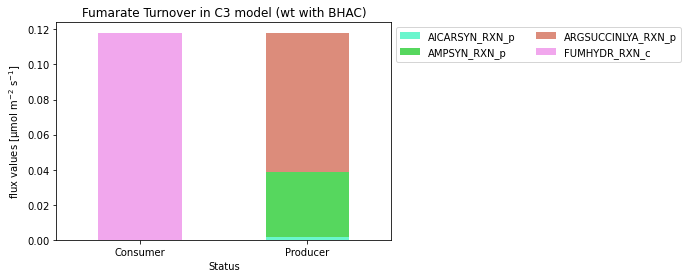

In [58]:
"""
Plot the pivot table and barplot
"""

#plt.style.use('dark_background')

chart = all_reactions.pivot_table(index="Status", columns="label", values="new_flux")
chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "flux values [\u03BCmol m$^{-2}$ s$^{-1}$]", color = color_dict)
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
plt.title("Fumarate Turnover in C3 model (wt without BHAC)")
figsize = [11, 11] #To prevent the cropping of the image
#plt.savefig('RedFed_NbyM_M.jpeg', format='jpeg', bbox_inches = 'tight')
#plt.savefig('figures/HC/OAA-ggt-bhac-rev.png', format='jpeg', bbox_inches = 'tight', dpi=300)
chart



In [59]:
c3_model.reactions.get_by_id('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p')

Reaction identifier,GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p
Name,GLUTAMATE-SYNTHASE-FERREDOXIN-RXN:Glutamate synthase (ferredoxin)
Memory address,0x019db372fc08
Stoichiometry,2_KETOGLUTARATE_p + GLN_p + 2.0 PROTON_p + 2.0 Reduced_ferredoxins_p --> 2.0 GLT_p + 2.0 Oxidized_ferredoxins_p 2-KETOGLUTARATE + GLN + 2.0 PROTON + 2.0 Reduced_ferredoxins[p] --> 2.0 GLT + 2.0 Oxidized_ferredoxins[p]
GPR,
Lower bound,0.0
Upper bound,1000.0


In [60]:
c3_model.metabolites.get_by_id('Oxidized_ferredoxins_p')

Metabolite identifier,Oxidized_ferredoxins_p
Name,Oxidized_ferredoxins[p]
Memory address,0x019db31237c8
Formula,X
Compartment,p
In 22 reaction(s),"GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p, RXN490_3650_p, hexadecadienoate_ACP_desaturase_p, MDA_Fd_Ascorbate_p, Arachidoyl_ACP_desaturase_p, RXN_7679_p, HMBPP_synthesis_p, RXN_7903_p, RXN_7978_p,..."


In [66]:
c3_model.reactions.get_by_id('ARGSUCCINLYA_RXN_p')

Reaction identifier,ARGSUCCINLYA_RXN_p
Name,ARGSUCCINLYA-RXN:Argininosuccinate lyase
Memory address,0x019db3643b88
Stoichiometry,L_ARGININO_SUCCINATE_p --> ARG_p + FUM_p + 0.07 PROTON_p L-ARGININO-SUCCINATE --> ARG + FUM + 0.07 PROTON
GPR,
Lower bound,0.0
Upper bound,1000.0


In [67]:
c3_model.reactions.get_by_id('AMPSYN_RXN_p')

Reaction identifier,AMPSYN_RXN_p
Name,AMPSYN-RXN:Adenylosuccinate lyase
Memory address,0x019db3555a88
Stoichiometry,ADENYLOSUCC_p --> AMP_p + FUM_p ADENYLOSUCC --> AMP + FUM
GPR,
Lower bound,0.0
Upper bound,1000.0


In [63]:
c3_model.reactions.get_by_id('THREONINE_ALDOLASE_RXN_c')

Reaction identifier,THREONINE_ALDOLASE_RXN_c
Name,THREONINE-ALDOLASE-RXN:Threonine aldolase
Memory address,0x019db3692ac8
Stoichiometry,THR_c --> ACETALD_c + GLY_c THR --> ACETALD + GLY
GPR,
Lower bound,0.0
Upper bound,1000.0


In [64]:
c3_model.metabolites.get_by_id('ACETALD_c')

Metabolite identifier,ACETALD_c
Name,ACETALD
Memory address,0x019db34bfb08
Formula,C2H4O1
Compartment,c
In 5 reaction(s),"RXN66_1_c, RXN66_3_c, ACETALD_mc, ALCOHOL_DEHYDROG_RXN_c, THREONINE_ALDOLASE_RXN_c"
